## Evaluating deep learning models using cross validation

In [ ]:
# import packages 
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling

import pandas as pd
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

In [2]:
# Data 
df = pd.read_csv("/Users/mauropazmino/Documents/Learning/Deep_learning_tensor/data/MIRS_temperature_vs_age_20241014.dat", sep="\t")

In [3]:
# Extract features and labels
X = np.asarray(df.iloc[:, 15:-1])
y = np.asarray(df.iloc[:,0])

from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)

X_resampled, y_resampled = rus.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

# Change the labels into 0 or 1
lb = LabelBinarizer()
y_binary = lb.fit_transform(y_resampled)

[('AC', 1724), ('AG', 1724)]


In [ ]:
#| label: crossvalidator
sss = StratifiedKFold(n_splits=5,
                      shuffle=True,
                      random_state=123)

# define the callbacks
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots()
  ]

In [ ]:
#| label: bigloop
histories = {}
for i, (train_index, test_index) in enumerate(sss.split(X_resampled, y_binary)):
    print(f"\nFold {i}:")
    keras.backend.clear_session()
    input_shape = [1796,]
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=input_shape))
    model.add(keras.layers.Dense(500, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    histories[f"fold{i}"] = model.fit(x=X_resampled[train_index], y=y_binary[train_index], epochs=2000, batch_size=250, validation_data=[X_resampled[test_index], y_binary[test_index]],verbose=0,callbacks=get_callbacks('model_baseline'))






Fold 0:

Epoch: 0, accuracy:0.5004,  loss:0.7859,  val_accuracy:0.5000,  val_loss:0.7151,  
....................................................................................................
Epoch: 100, accuracy:0.6302,  loss:0.6369,  val_accuracy:0.6261,  val_loss:0.6385,  
....................................................................................................
Epoch: 200, accuracy:0.6925,  loss:0.5858,  val_accuracy:0.6826,  val_loss:0.5977,  
....................................................................................................
Epoch: 300, accuracy:0.6958,  loss:0.5760,  val_accuracy:0.6290,  val_loss:0.6426,  
....................................................................................................
Epoch: 400, accuracy:0.7288,  loss:0.5394,  val_accuracy:0.7000,  val_loss:0.5660,  
....................................................................................................
Epoch: 500, accuracy:0.7194,  loss:0.5430,  val_accuracy:0.687

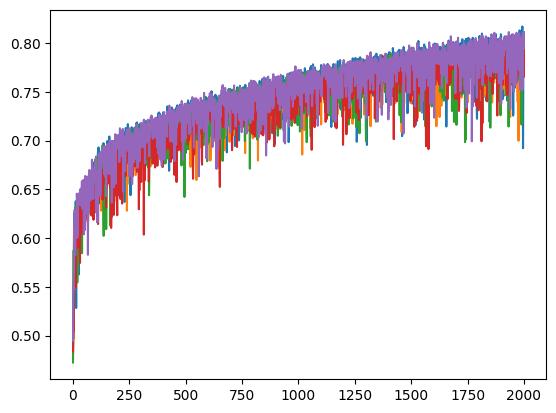

In [ ]:
#| label: plot
plt.plot(range(1, len(histories['fold0'].history['accuracy']) + 1), histories['fold0'].history['accuracy'])
plt.plot(range(1, len(histories['fold1'].history['accuracy']) + 1), histories['fold1'].history['accuracy'])
plt.plot(range(1, len(histories['fold1'].history['accuracy']) + 1), histories['fold2'].history['accuracy'])
plt.plot(range(1, len(histories['fold1'].history['accuracy']) + 1), histories['fold3'].history['accuracy'])
plt.plot(range(1, len(histories['fold1'].history['accuracy']) + 1), histories['fold4'].history['accuracy'])




In [72]:
#|label: dataframe
acc_total = []
for key in histories.keys():
    acc_df = pd.DataFrame()
    acc_df['val_accuracy'] = pd.DataFrame(histories[key].history['val_accuracy'])
    acc_df['accuracy'] = pd.DataFrame(histories[key].history['accuracy'])
    acc_df['type'] = key
    acc_df['epochs'] = range(1, len(histories[key].history['accuracy']) + 1)
    acc_total.append(acc_df)

df_total = pd.concat(acc_total)
df_total

,val_accuracy,accuracy,type,epochs
0,0.500000,0.500363,fold0,1
1,0.498551,0.505801,fold0,2
2,0.518841,0.542422,fold0,3
3,0.543478,0.542785,fold0,4
4,0.620290,0.600435,fold0,5
...,...,...,...,...
1995,0.780842,0.794853,fold4,1996
1996,0.801161,0.802102,fold4,1997
1997,0.770682,0.810801,fold4,1998
1998,0.799710,0.793766,fold4,1999


(0.2, 1.0)

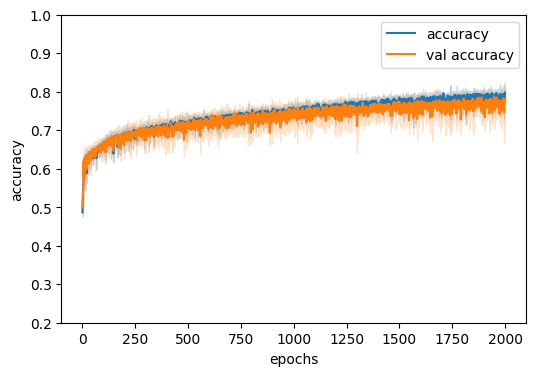

In [ ]:
#| label: finalplot

import seaborn as sns


fig, ax = plt.subplots(figsize=(6,4))
sns.lineplot(data=df_total, x="epochs", y="accuracy", errorbar=('sd', 1), ax=ax, label='accuracy')
sns.lineplot(data=df_total, x="epochs", y="val_accuracy", errorbar=('sd', 1), ax=ax, label= 'val accuracy')
ax.set_ylim(0.2, 1)